In [1]:
import warnings                                  # `do not disturb` mode
warnings.filterwarnings('ignore')

from dateutil.relativedelta import relativedelta # working with dates with style
import hvplot as hv
import hvplot.pandas
from itertools import product                    # some useful functions
import matplotlib.pyplot as plt                  # plots
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
from pathlib import Path
from pypalettes import load_cmap, add_cmap
import seaborn as sns                            # more plots
from scipy.optimize import minimize              # for function minimization
import scipy.stats as scs
from sklearn.metrics import mean_absolute_percentage_error as mape
import statsmodels.api as sm
import statsmodels.formula.api                     # statistics and econometrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tqdm

# Set plot styles
plt.rcParams["figure.figsize"] = [30, 5]
plt.style.use('grayscale')


# Festlegen der Farben
cmap = load_cmap("Apricot")
cmap_continuous = add_cmap(
    colors=["#FFFFFFFF", "#FFF9A1FF", "#BAD09DFF", "#76D3CFFF", "#459E9EFF", "#306677FF", "#24385FFF", "#132157FF"],
    name="apricot_continuous",
    cmap_type="continuous"
)
cmap8 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#005F73FF', '#9093A2FF', '#132157FF'],
    name="apricot8colors",
    cmap_type="discrete"
)
cmap7 = add_cmap(
    colors=['#D72000FF', '#EE6100FF', '#FFAD0AFF', '#FFD700FF', '#1BB6AFFF', '#9093A2FF', '#132157FF'],
    name="apricot7colors",
    cmap_type="discrete"
)


%matplotlib inline



In [3]:
# Load Timestamp of Dataset
df_daily = pd.read_csv('df_daily.csv')
df_hourly = pd.read_csv('df_hourly_2020.csv')
df_daily_test = pd.read_csv('df_daily_2024.csv')
df_hourly_test = pd.read_csv('df_hourly_2024.csv')


## Time series analysis in Python
Analyse aus: https://www.kaggle.com/code/kashnitsky/topic-9-part-1-time-series-analysis-in-python/notebook 25.07.24, 10:56
Und aus Atwan.2022: *Time Series Analysis*. 10 Building Univariate Time Series Models Using Statistical Methods: https://learning.oreilly.com/library/view/time-series-analysis/9781805124283/text/ch011.xhtml#join-our-book-community-on-discord-9

### Hilfsfunkktionen: check_stationarity, get_top_models_df, plot_forecast, combinator

In [78]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(),
                           key=lambda item: item[1][criterion])
   
    top_models = sorted_scores[:top_n]
    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
   
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)
    return df

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

def mean_absolute_error(actual, predicted):
    """
    Berechnet den mittleren absoluten Fehler (MAE) zwischen zwei Zeitreihen.
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte (z. B. gleitender Mittelwert).
        
    Returns:
        float: Der mittlere absolute Fehler.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean(np.abs(actual - predicted))

def mean_squared_error(actual, predicted):
    """
    Berechnet den mittleren quadratischen Fehler (MSE) zwischen zwei Zeitreihen.
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte.
        
    Returns:
        float: Der mittlere quadratische Fehler.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean((actual - predicted) ** 2)

def mean_squared_log_error(actual, predicted):
    """
    Berechnet den mittleren logarithmischen quadratischen Fehler (MSLE).
    
    Parameters:
        actual (pd.Series or np.ndarray): Die tatsächlichen Werte.
        predicted (pd.Series or np.ndarray): Die vorhergesagten Werte.
        
    Returns:
        float: Der MSLE.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    return np.mean((np.log1p(actual) - np.log1p(predicted)) ** 2)

def mean_absolute_percentage_error(y_true, y_pred): 
    """
    Calculate the mean absolute percentage error (MAPE)
    
    Parameters:
        y_true (array-like): Actual values
        y_pred (array-like): Predicted values
    
    Returns:
        float: MAPE value in percentage
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_indices = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_indices] - y_pred[nonzero_indices]) / y_true[nonzero_indices])) * 100

def combinator(items):
    combo = [i for i in product(*items)]
    return combo

# Random Forest Prediction

In [76]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(df_daily.calls.copy())
data.columns = ["y"]

In [46]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 31):
    data["lag_{}".format(i)] = data.y.shift(i)

In [47]:
# take a look at the new dataframe 
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
3645,325.0,394.0,406.0,250.0,2.0,329.0,401.0,376.0,398.0,459.0,...,508.0,361.0,350.0,437.0,458.0,426.0,428.0,540.0,374.0,347.0
3646,485.0,391.0,394.0,406.0,250.0,2.0,329.0,401.0,376.0,398.0,...,431.0,508.0,361.0,350.0,437.0,458.0,426.0,428.0,540.0,374.0
3647,405.0,346.0,391.0,394.0,406.0,250.0,2.0,329.0,401.0,376.0,...,369.0,431.0,508.0,361.0,350.0,437.0,458.0,426.0,428.0,540.0
3648,372.0,339.0,346.0,391.0,394.0,406.0,250.0,2.0,329.0,401.0,...,374.0,369.0,431.0,508.0,361.0,350.0,437.0,458.0,426.0,428.0
3649,363.0,263.0,339.0,346.0,391.0,394.0,406.0,250.0,2.0,329.0,...,340.0,374.0,369.0,431.0,508.0,361.0,350.0,437.0,458.0,426.0
3650,299.0,244.0,263.0,339.0,346.0,391.0,394.0,406.0,250.0,2.0,...,287.0,340.0,374.0,369.0,431.0,508.0,361.0,350.0,437.0,458.0
3651,229.0,325.0,244.0,263.0,339.0,346.0,391.0,394.0,406.0,250.0,...,268.0,287.0,340.0,374.0,369.0,431.0,508.0,361.0,350.0,437.0


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [49]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [50]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [51]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [79]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

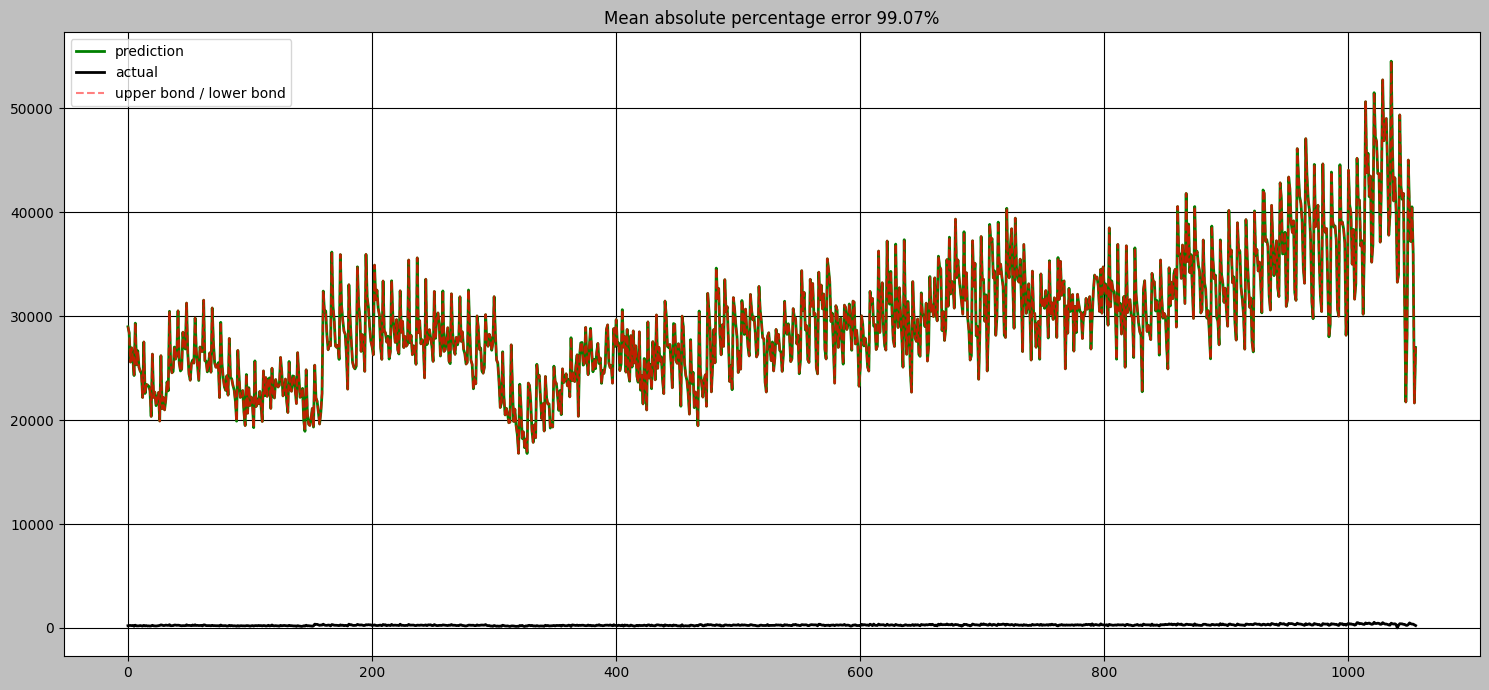

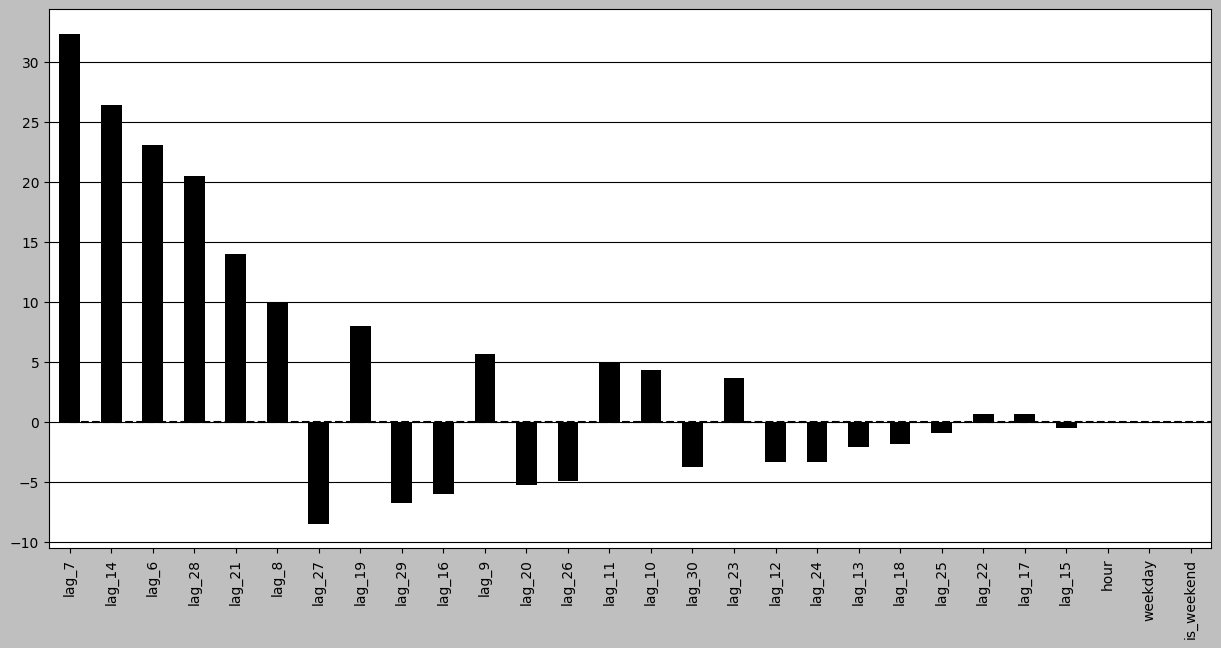

In [80]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [82]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,hour,weekday,is_weekend
1970-01-01 00:00:00.000003647,405.0,0,3,0
1970-01-01 00:00:00.000003648,372.0,0,3,0
1970-01-01 00:00:00.000003649,363.0,0,3,0
1970-01-01 00:00:00.000003650,299.0,0,3,0
1970-01-01 00:00:00.000003651,229.0,0,3,0


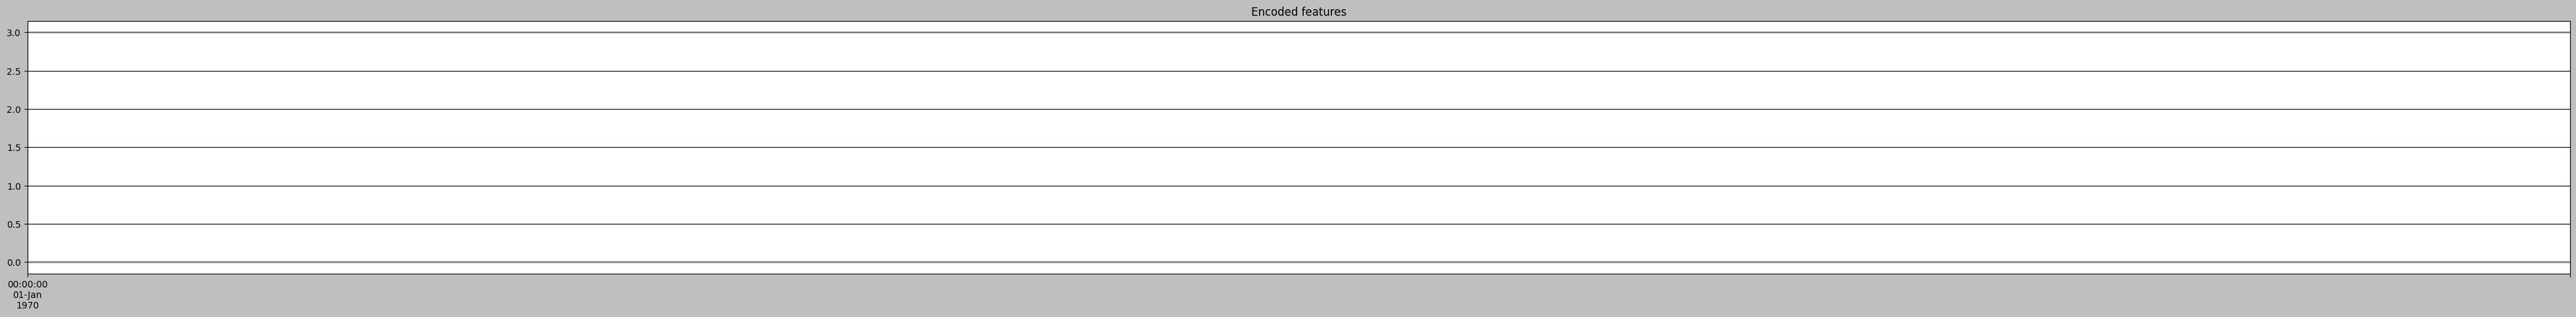

In [83]:
plt.figure(figsize=(50, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

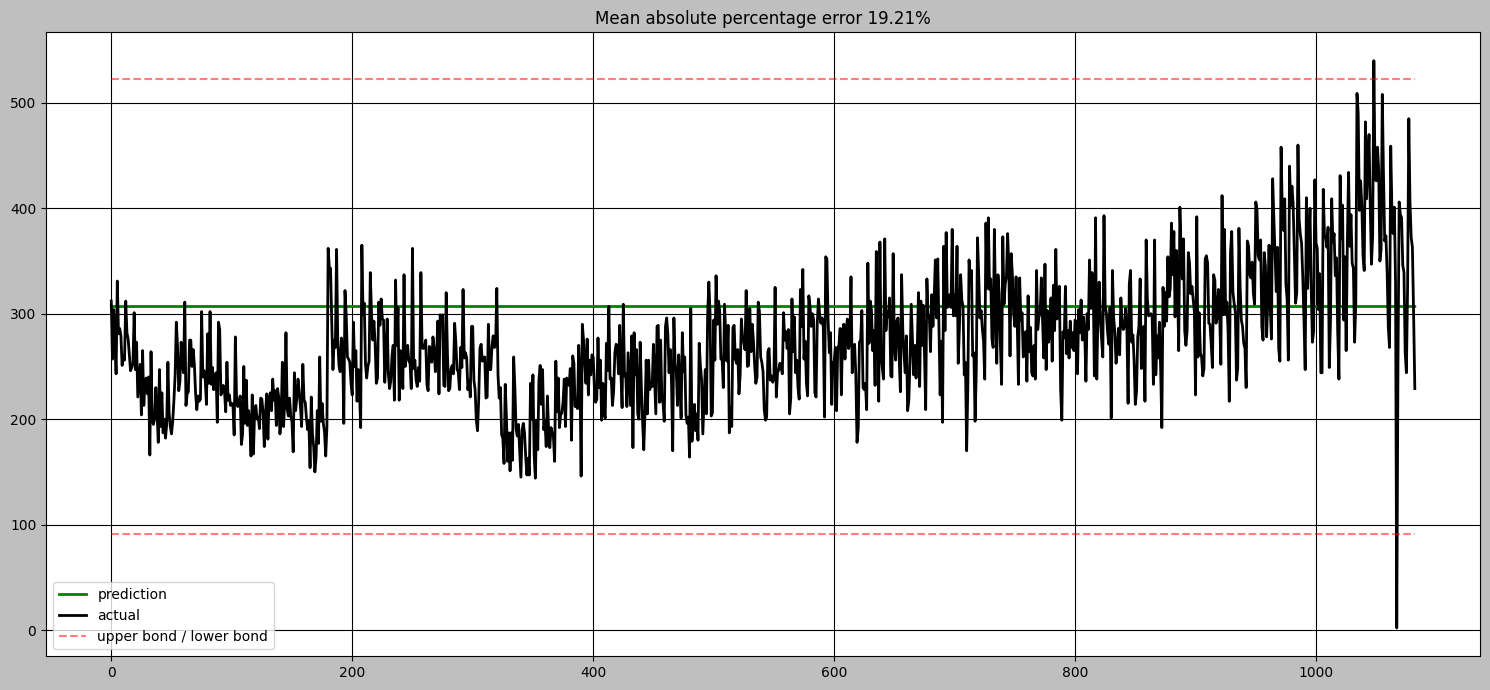

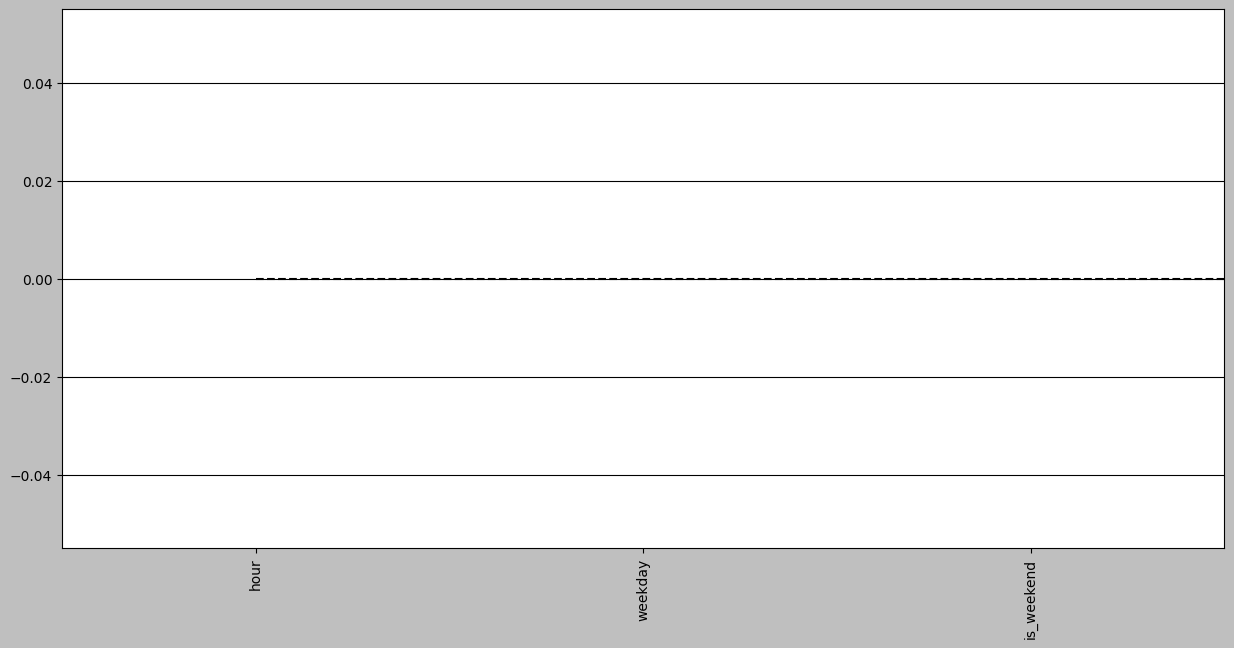

In [85]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

In [86]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [87]:
average_weekday = code_mean(data, 'weekday', "y")

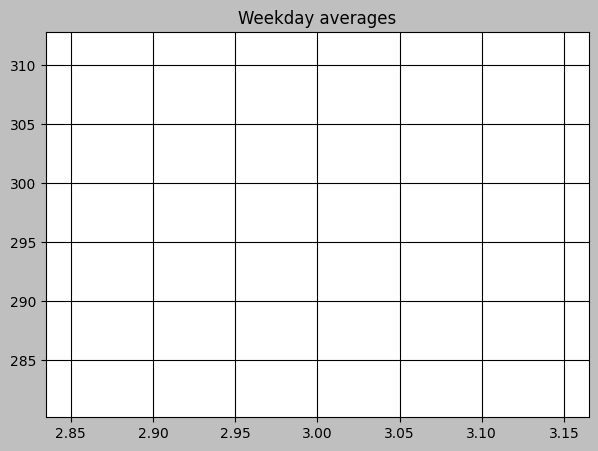

In [88]:
average_weekday = code_mean(data, 'weekday', "y")
plt.figure(figsize=(7, 5))
plt.title("Weekday averages")
pd.DataFrame.from_dict(average_weekday, orient='index')[0].plot()
plt.grid(True)

In [89]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))

        # frop encoded variables 
        data.drop(["weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

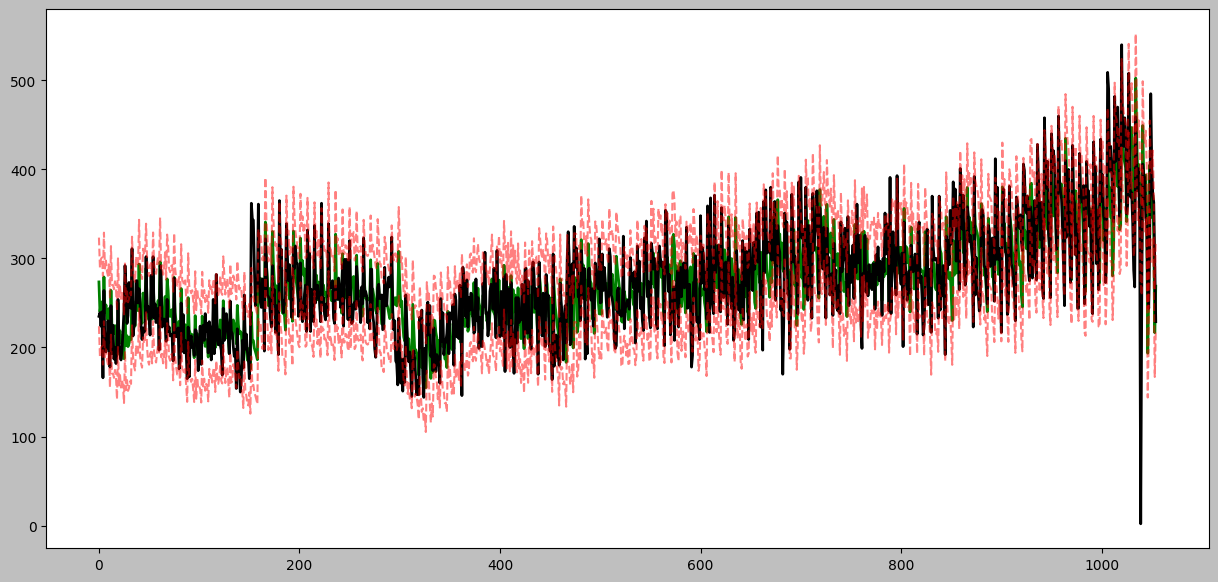

In [90]:
X_train, X_test, y_train, y_test = prepareData(df_daily.calls, lag_start=7, lag_end=32, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [91]:
X_train, X_test, y_train, y_test =\
prepareData(df_daily.calls, lag_start=7, lag_end=32, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<Axes: >

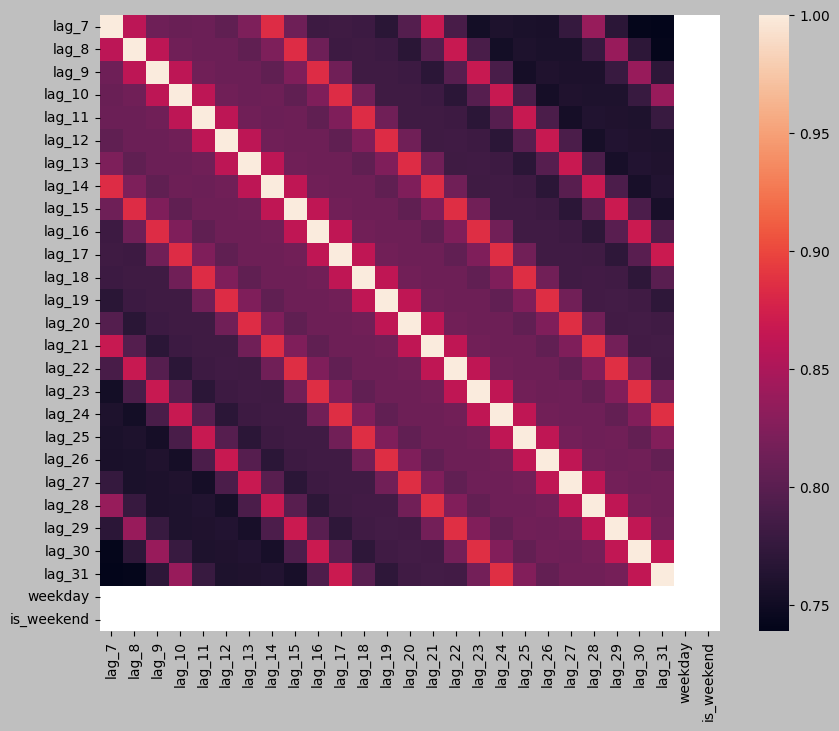

In [93]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr())

AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

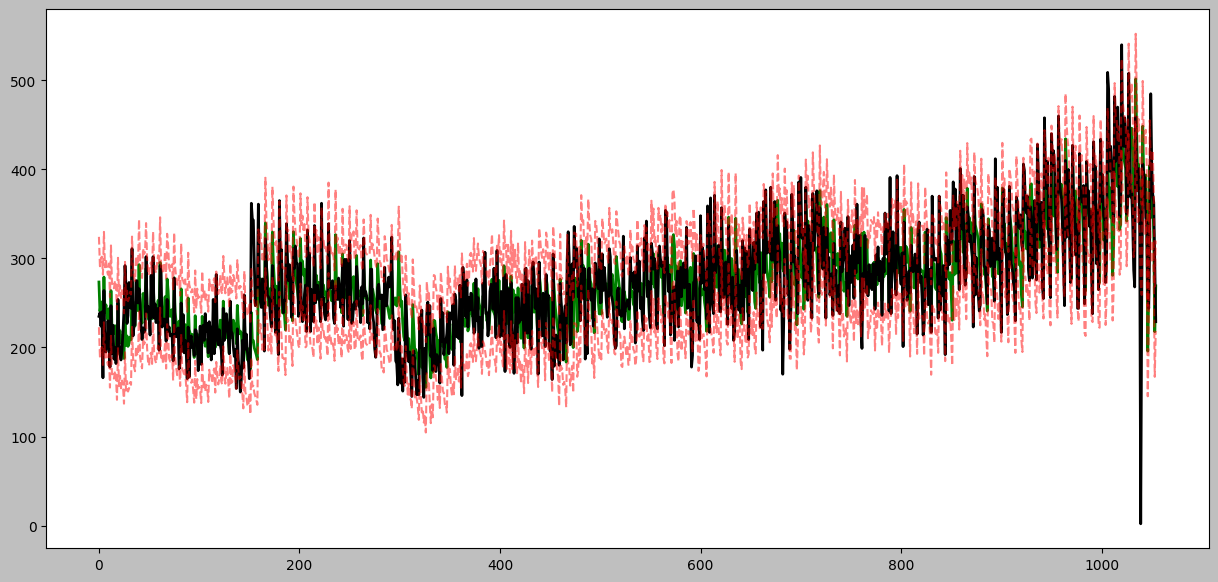

In [94]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

AttributeError: `np.NaN` was removed in the NumPy 2.0 release. Use `np.nan` instead.

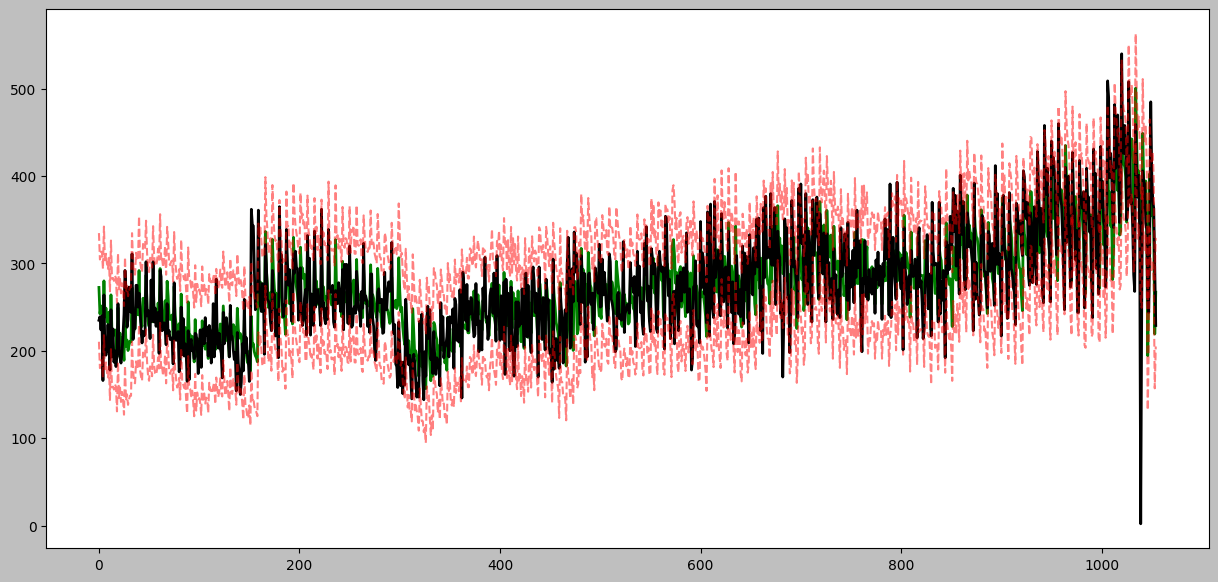

In [95]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)